In [1]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import seaborn as sns
import scipy as sp
import numpy as np
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import  TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
import re
from nltk.corpus import stopwords

from ast import literal_eval

requirements = pd.read_csv('../../crowdre_question/requirements.csv')

req = pd.DataFrame(requirements, columns = ['feature','benefit','application_domain', 'application_domain_other'])
req['sentence']= req['feature'] + ', ' + req['benefit']
req.drop(['feature','benefit'],axis=1, inplace=True)

In [2]:
req.head()

,application_domain,application_domain_other,sentence
0,Health,NaN,my smart home to be able to order delivery foo...
1,Energy,NaN,my smart home to turn on certain lights at dus...
2,Entertainment,NaN,my smart home to sync with my biorhythm app an...
3,Entertainment,NaN,my smart home to to ring when my favorite show...
4,Energy,NaN,"Class Reminders, I won't be late for class"


In [3]:
req.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2966 entries, 0 to 2965
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   application_domain        2966 non-null   object
 1   application_domain_other  543 non-null    object
 2   sentence                  2966 non-null   object
dtypes: object(3)
memory usage: 69.6+ KB


In [4]:
req.application_domain.unique()

array(['Health', 'Energy', 'Entertainment', 'Safety', 'Other'],
      dtype=object)

In [5]:
for other, index in zip(req['application_domain_other'], range(len(req['application_domain_other']))):
    if type(other)!=float:
        req['application_domain_other'][index] = other.lower()
    
pd.set_option('display.max_rows', None)
req['application_domain_other'].value_counts()

application_domain_other
convenience                     66
comfort                         24
safety                          22
security                        22
pets                            21
food                            18
health                          16
energy                          14
pet care                        13
time saving                     12
cleaning                        12
cooking                         12
kitchen                          9
cleanliness                      8
productivity                     6
water                            6
environment                      5
maintenance                      5
parenting                        4
work                             4
education                        4
energy                           4
aesthetics                       4
hygiene                          4
groceries                        4
appliances                       4
water conservation               3
laze                          

In [6]:
y = req['application_domain']
keep_list = ['health', 'energy', 'entertainment', 'safety']

for domain, index in zip(req['application_domain'], range(len(y))):
    
    if domain != 'Other':
        new_domain = domain.lower()
        req['application_domain'][index] = new_domain
    elif domain == 'Other':
        if req['application_domain_other'][index] in keep_list:
            req['application_domain'][index] = req['application_domain_other'][index]
        else:
            req.drop(index, inplace= True)

req.reset_index(drop=True, inplace=True)
req.drop(['application_domain_other'],axis=1, inplace=True)
req.head()

,application_domain,sentence
0,health,my smart home to be able to order delivery foo...
1,energy,my smart home to turn on certain lights at dus...
2,entertainment,my smart home to sync with my biorhythm app an...
3,entertainment,my smart home to to ring when my favorite show...
4,energy,"Class Reminders, I won't be late for class"


In [7]:
req.application_domain.unique()

array(['health', 'energy', 'entertainment', 'safety'], dtype=object)

In [8]:
train, test = train_test_split(req, test_size=0.3, random_state=10)
print(len(train))
print(len(test))

train.sample(10)

1808
776


,application_domain,sentence
2576,health,"my fridge to detect when food spoils, I don't ..."
443,safety,smart floors and furniture that can tell me if...
1505,entertainment,smart home that integrates with every tv in ea...
367,health,my treadmill to alert me when I haven't used i...
2580,safety,the house to notify me when my children are ho...
1569,energy,my dryer to sound when the clothes are finishe...
984,energy,"solar system, it gives more money savings"
2529,entertainment,a device that can greet me and hold conversati...
2567,health,"to receive a notification from smartphone, I k..."
2224,safety,a monitor to notify EMS if I don't move for mo...


In [9]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]') 
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    text = text.lower() 
    text = REPLACE_BY_SPACE_RE.sub(' ',text) 
    text = BAD_SYMBOLS_RE.sub('',text)
    join_list = []
    for w in text.split():
        if w not in STOPWORDS:
            '''# do lemmatization
            lemmatizer = WordNetLemmatizer()
            lemma_w = lemmatizer.lemmatize(w, 'n')'''

            # special case
            if w == 'television':
                w = 'tv'

            '''# do stemming here
            stemmer = nltk.stem.SnowballStemmer('english')
            stem_w = stemmer.stem(lemma_w)
            
            join_list.append(stem_w)'''
            join_list.append(w)
            
            
            
    text = ' '.join(join_list)
    #text = ' '.join([w for w in text.split() if w not in STOPWORDS])
    return text

In [10]:
X_train, y_train = train.sentence, train.application_domain
X_test, y_test = test.sentence, test.application_domain
 
#data clean
X_train = [text_prepare(x) for x in X_train]
X_test = [text_prepare(x) for x in X_test]
X_train[:10]

['device tells pet gets room something theyre meant ie trash get soomer',
 'pet bed automatically warm cool depending temperature pet pet always comfort',
 'music play kitchen listen music cooking cleanin',
 'know much humidity house turn water starts get dry',
 'oven function im kitchen kids wont hurt',
 'smart solar panels adjust sunlight collected efficiently',
 'optimized lighting system people think home',
 'home filled entertainment host events',
 'refrigerator remind went low certain item stop get way home save trips store',
 'notify shortage kitchen product buy time']

In [11]:
cv = CountVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')
feature = cv.fit_transform(X_train)
print(feature.shape)
print(feature)

(1808, 926)
  (0, 207)	1
  (0, 803)	1
  (0, 602)	1
  (0, 336)	1
  (0, 683)	1
  (0, 759)	1
  (0, 813)	1
  (0, 334)	1
  (1, 602)	3
  (1, 90)	1
  (1, 71)	1
  (1, 881)	1
  (1, 181)	1
  (1, 198)	1
  (1, 805)	1
  (1, 39)	1
  (2, 545)	2
  (2, 613)	1
  (2, 434)	1
  (2, 473)	1
  (2, 180)	1
  (2, 547)	1
  (2, 474)	1
  (3, 334)	1
  (3, 435)	1
  :	:
  (1805, 62)	1
  (1805, 0)	1
  (1805, 426)	1
  (1805, 290)	1
  (1805, 916)	1
  (1805, 63)	1
  (1806, 683)	1
  (1806, 39)	1
  (1806, 466)	1
  (1806, 219)	1
  (1806, 467)	1
  (1806, 733)	1
  (1806, 448)	1
  (1806, 671)	1
  (1806, 70)	1
  (1806, 451)	1
  (1807, 794)	1
  (1807, 697)	1
  (1807, 522)	1
  (1807, 250)	1
  (1807, 700)	1
  (1807, 509)	1
  (1807, 208)	1
  (1807, 689)	1
  (1807, 148)	1


In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
 
def print_evaluation_scores(y_val, predicted):
    accuracy=accuracy_score(y_val, predicted)
    f1_score_macro=f1_score(y_val, predicted, average='macro')
    f1_score_micro=f1_score(y_val, predicted, average='micro')
    f1_score_weighted=f1_score(y_val, predicted, average='weighted')
    print("accuracy:",accuracy)
    print("f1_score_macro:",f1_score_macro)
    print("f1_score_micro:",f1_score_micro)
    print("f1_score_weighted:",f1_score_weighted)

In [13]:
#print(y_train.values[1])

In [14]:
# from sklearn.preprocessing import OneHotEncoder
# classes = ['health', 'safety', 'entertainment', 'energy']
# encoder = OneHotEncoder(categories=[classes])

# y_train1 = []
# y_test1 = []
# for i in range(len(y_train.values)):
#     y_train1.append(y_train.values[i])
    
# for i in range(len(y_test)):
#     y_test1.append(y_test.values[i])

    
# y_train1 = np.array(y_train1).reshape(-1,1)
# y_test1 = np.array(y_test1).reshape(-1,1)

# y_train = encoder.fit_transform(y_train1).toarray()
# y_test = encoder.fit_transform(y_test1).toarray()
# #y_test = encoder.transform([[l] for l in y_test.values]).toarray()
# print(y_train)

In [15]:
# encoder.categories_

In [16]:
NB_pipeline = Pipeline([
                ('cv', CountVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])
 
NB_pipeline.fit(X_train,y_train)
predicted_NB = NB_pipeline.predict(X_test)
print_evaluation_scores(y_test,predicted_NB)

accuracy: 0.720360824742268
f1_score_macro: 0.7079326723671444
f1_score_micro: 0.7203608247422679
f1_score_weighted: 0.7181688311960427


In [17]:
print(predicted_NB)

['energy' 'energy' 'energy' 'energy' 'entertainment' 'safety' 'health'
 'health' 'safety' 'health' 'health' 'safety' 'safety' 'health' 'safety'
 'entertainment' 'energy' 'energy' 'safety' 'safety' 'energy' 'safety'
 'safety' 'energy' 'safety' 'energy' 'entertainment' 'energy' 'safety'
 'safety' 'safety' 'safety' 'health' 'health' 'safety' 'safety' 'health'
 'safety' 'health' 'safety' 'energy' 'safety' 'health' 'safety' 'health'
 'safety' 'energy' 'energy' 'safety' 'energy' 'entertainment'
 'entertainment' 'safety' 'entertainment' 'health' 'safety' 'health'
 'health' 'energy' 'health' 'entertainment' 'health' 'entertainment'
 'health' 'safety' 'entertainment' 'health' 'safety' 'health' 'energy'
 'safety' 'safety' 'safety' 'safety' 'entertainment' 'safety' 'energy'
 'safety' 'health' 'safety' 'health' 'entertainment' 'safety' 'energy'
 'safety' 'energy' 'energy' 'energy' 'safety' 'energy' 'energy'
 'entertainment' 'entertainment' 'energy' 'entertainment' 'safety'
 'energy' 'safety' 'ener

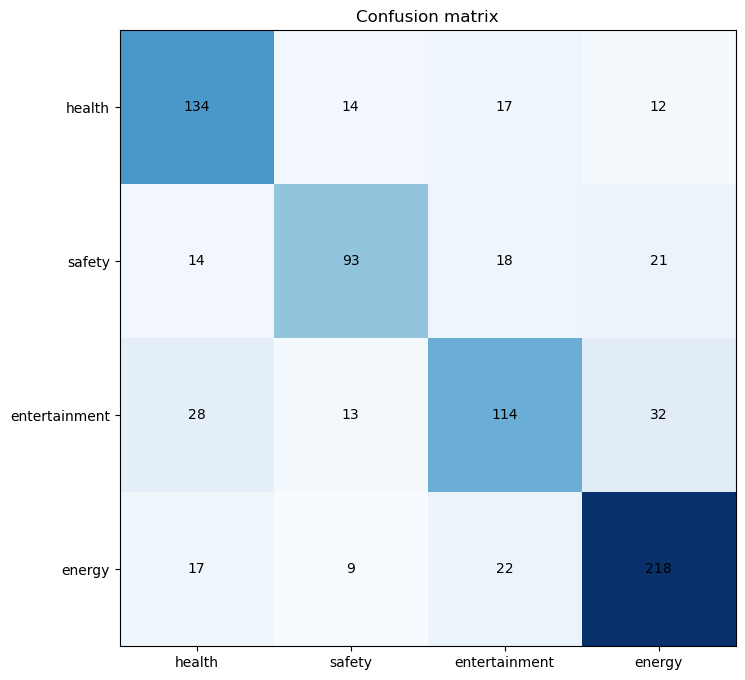

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have y_test and predicted_NB already defined

# Convert y_test and predicted_NB to arrays if they are not already
y_true = np.array(y_test)
y_pred = np.array(predicted_NB)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(conf_mat, cmap='Blues')

# Set labels and ticks
classes = ['health', 'safety', 'entertainment', 'energy']
ax.set_title('Confusion matrix')
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

# Add text annotations
for i in range(len(classes)):
    for j in range(len(classes)):
        ax.text(j, i, conf_mat[i, j], ha='center', va='center', color='black')

# Display the plot
plt.show()


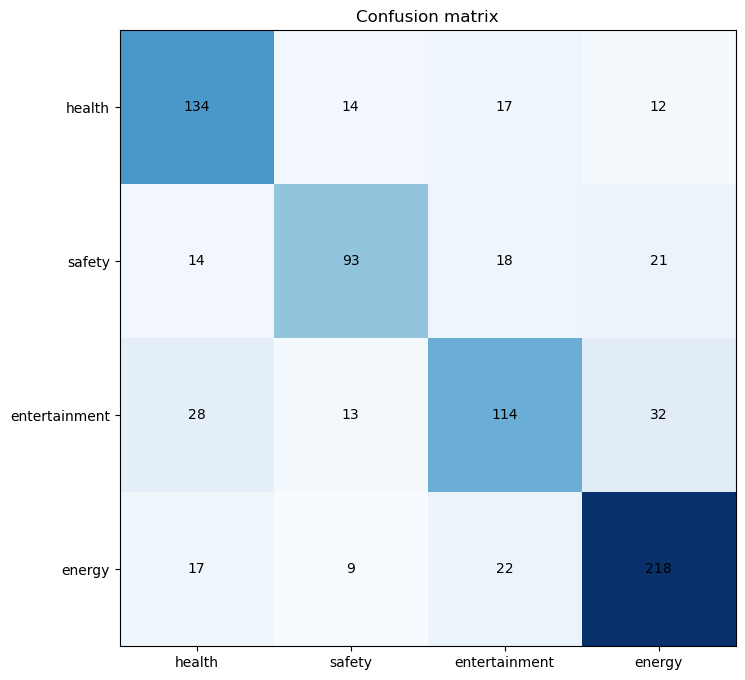

In [19]:
# draw confuson matrix for CV + NB: y_test
from sklearn.metrics import confusion_matrix

y_true = []
y_pred = []

if y_test.shape[0] == predicted_NB.shape[0]:
    for i in range(y_test.shape[0]):
        y_true.append(y_test.values[i])
        y_pred.append(predicted_NB[i])

y_true = np.array(y_test)
y_pred = np.array(predicted_NB)

# Compute the confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix as a heatmap
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(conf_mat, cmap='Blues')
ax.set_title('Confusion matrix')
ax.set_xticks(np.arange(len(conf_mat)))
ax.set_yticks(np.arange(len(conf_mat)))
ax.set_xticklabels(['health', 'safety', 'entertainment', 'energy'])
ax.set_yticklabels(['health', 'safety', 'entertainment', 'energy'])
for i in range(len(conf_mat)):
    for j in range(len(conf_mat)):
        ax.text(j, i, conf_mat[i, j], ha='center', va='center', color='black')
plt.show()

In [20]:
SVC_pipeline = Pipeline([
                ('cv', CountVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
 
SVC_pipeline.fit(X_train,y_train)
predicted_SVC = SVC_pipeline.predict(X_test)
print_evaluation_scores(y_test,predicted_SVC)

accuracy: 0.6507731958762887
f1_score_macro: 0.6372657711616541
f1_score_micro: 0.6507731958762887
f1_score_weighted: 0.6487063513572668


/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [21]:
LogReg_pipeline = Pipeline([
                ('cv', CountVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=1)),
            ])
 
LogReg_pipeline.fit(X_train,y_train)
predicted_Log = LogReg_pipeline.predict(X_test)
print_evaluation_scores(y_test,predicted_Log)

accuracy: 0.6958762886597938
f1_score_macro: 0.6813872195830823
f1_score_micro: 0.6958762886597938
f1_score_weighted: 0.6917340407496257


In [22]:
tfidf_NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(MultinomialNB())),
            ])
 
tfidf_NB_pipeline.fit(X_train,y_train)
tfidf_NB_predicted = tfidf_NB_pipeline.predict(X_test)
print_evaluation_scores(y_test,tfidf_NB_predicted)

accuracy: 0.7061855670103093
f1_score_macro: 0.6901521873680229
f1_score_micro: 0.7061855670103093
f1_score_weighted: 0.7008950605540096


In [23]:
tfidf_SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

tfidf_SVC_pipeline.fit(X_train,y_train)
tfidf_SVC_predicted = tfidf_SVC_pipeline.predict(X_test)

print_evaluation_scores(y_test,tfidf_SVC_predicted)

/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/davidzhan/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


accuracy: 0.6881443298969072
f1_score_macro: 0.6738234699807378
f1_score_micro: 0.6881443298969072
f1_score_weighted: 0.6840116711868212


In [24]:
tfidf_LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(min_df=5,max_df=0.9,ngram_range=(1,2),token_pattern= '(\S+)')),
                ('clf', OneVsRestClassifier(LogisticRegression(), n_jobs=1)),
            ])
 
tfidf_LogReg_pipeline.fit(X_train,y_train)
tfidf_LogReg_predicted = tfidf_LogReg_pipeline.predict(X_test)
print_evaluation_scores(y_test,tfidf_LogReg_predicted)

accuracy: 0.7023195876288659
f1_score_macro: 0.6856005186445719
f1_score_micro: 0.7023195876288659
f1_score_weighted: 0.6959776750713195


In [25]:
# allocate tags for set 1
# set 1 data
scenarios = pd.read_csv('../../cleaned_dataset/senario.csv')
sc = pd.DataFrame(scenarios, columns = ['id','context','stimuli','response'])
sc['sentence']= sc['context'] + ', ' + sc['stimuli'] + ', ' +sc['response']
sc.drop(['context','stimuli','response'],axis=1, inplace=True)
sc.dropna(inplace=True)
sc.reset_index(drop=True, inplace=True)
sc.columns=['scenarios_id','sentence']
cv = sc.copy()
tf = sc.copy()
sc.head()

,scenarios_id,sentence
0,7,"my sensor should detect movement, if i get up ..."
1,8,the house should automatically detect movement...
2,9,"movement should be detected, if there is movem..."
3,10,"if a person is reading, the house should chang..."
4,11,There is a storm outside or it is very hot and...


In [26]:
# clean set 1 sentence
XX_test = sc['sentence']
print(type(XX_test[0]))
Xx_test = [text_prepare(x) for x in XX_test]
Xx_test[:10]

<class 'str'>


['sensor detect movement get late night lights house go',
 'house automatically detect movement person walks dark room lights go enhance convenience safety',
 'movement detected movement outside house lights go visibility dark night',
 'person reading house change lightning brightness color lights turn bright white person see reading',
 'storm outside hot ac blowing cool air house wind fan may blowing curtains system able determine continuous motion small degree therefore register continue shut lights designated time',
 'late night shopping trip person gets home late night hands full cant switch lights system instantly turn lights motion detected',
 'someone malicious intent scoping house potentially rob person prowling around yard smart homeowner exterior lights recognize normal times guest authorized person key holder turn lights',
 'night time couple relaxing glass whine watching movie evening man romantic house guest sitting couch living room light system recognize getting late mov

In [27]:
set1_predicted_NB = NB_pipeline.predict(Xx_test)
set1_predicted_NB

array(['safety', 'safety', 'safety', ..., 'energy', 'entertainment',
       'energy'], dtype='<U13')

In [28]:
cv['domain'] = set1_predicted_NB
cv.head()

,scenarios_id,sentence,domain
0,7,"my sensor should detect movement, if i get up ...",safety
1,8,the house should automatically detect movement...,safety
2,9,"movement should be detected, if there is movem...",safety
3,10,"if a person is reading, the house should chang...",energy
4,11,There is a storm outside or it is very hot and...,energy


In [29]:
cv.set_index('scenarios_id',inplace=True)
cv.to_csv('./predicted_domain4all_requirements.csv')
cv.head()

,sentence,domain
scenarios_id,,
7,"my sensor should detect movement, if i get up ...",safety
8,the house should automatically detect movement...,safety
9,"movement should be detected, if there is movem...",safety
10,"if a person is reading, the house should chang...",energy
11,There is a storm outside or it is very hot and...,energy
